Week 9: Gradient Boosting for NFL Injury Prevention

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)


Data Preparation

In [17]:
# Load data 
try:
    injury_data = pd.read_csv('data/InjuryRecord.csv')
    video_data = pd.read_csv('data/video_review.csv') 
    plays_data = pd.read_csv('data/plays.csv')
    
    print(f" All datasets loaded successfully")
    print(f" InjuryRecord: {injury_data.shape[0]} records, {injury_data.shape[1]} columns")
    print(f" VideoReview: {video_data.shape[0]} records, {video_data.shape[1]} columns")
    print(f" PlaysData: {plays_data.shape[0]} records, {plays_data.shape[1]} columns")
except FileNotFoundError as e:
    print(f" Error loading files: {e}")
    print(" Trying alternative paths and creating sample data...")
    try:
        injury_data = pd.read_csv('data/InjuryRecord.csv')
        video_data = pd.read_csv('data/video_review.csv') 
        plays_data = pd.read_csv('data/plays.csv')
        print(f" All datasets loaded from data/ folder")
    except FileNotFoundError:
        print(" Creating enhanced sample data for demonstration...")
        injury_data = pd.DataFrame({
            'PlayerKey': range(1, 106),
            'GameID': [f'{i}-{j}' for i in range(1, 106) for j in [1]],
            'PlayKey': [f'{i}-{j}-{k}' for i in range(1, 106) for j in [1] for k in [1]],
            'BodyPart': np.random.choice(['Knee', 'Ankle', 'Foot', 'Toes', 'Heel'], 105, p=[0.46, 0.40, 0.07, 0.06, 0.01]),
            'Surface': np.random.choice(['Natural', 'Synthetic'], 105, p=[0.46, 0.54]),
            'DM_M1': np.ones(105),  # All miss at least 1 day
            'DM_M7': np.random.choice([0, 1], 105, p=[0.28, 0.72]),
            'DM_M28': np.random.choice([0, 1], 105, p=[0.65, 0.35]),
            'DM_M42': np.random.choice([0, 1], 105, p=[0.72, 0.28])
        })
        video_data = pd.DataFrame({
            'Season_Year': [2016] * 37,
            'GameKey': range(1, 38),
            'PlayID': range(1, 38),
            'GSISID': range(1, 38),
            'Player_Activity_Derived': np.random.choice(['Tackling', 'Blocking', 'Tackled', 'Blocked'], 37, p=[0.35, 0.27, 0.16, 0.22]),
            'Turnover_Related': np.random.choice(['No', 'Yes'], 37, p=[0.9, 0.1]),
            'Primary_Impact_Type': np.random.choice(['Helmet-to-body', 'Helmet-to-helmet', 'Helmet-to-ground', 'Unclear'], 37, p=[0.46, 0.46, 0.05, 0.03]),
            'Friendly_Fire': np.random.choice(['No', 'Yes'], 37, p=[0.84, 0.16])
        })
        plays_data = pd.DataFrame({
            'gameId': range(2021090900, 2021090900 + 8557),
            'playId': range(1, 8558),
            'quarter': np.random.choice([1, 2, 3, 4], 8557, p=[0.25, 0.25, 0.25, 0.25]),
            'down': np.random.choice([1, 2, 3, 4], 8557, p=[0.35, 0.25, 0.25, 0.15]),
            'yardsToGo': np.random.randint(1, 21, 8557),
            'possessionTeam': np.random.choice(['TB', 'DAL', 'NE', 'KC', 'GB', 'SF'], 8557),
            'defensiveTeam': np.random.choice(['TB', 'DAL', 'NE', 'KC', 'GB', 'SF'], 8557),
            'offenseFormation': np.random.choice(['SHOTGUN', 'SINGLEBACK', 'EMPTY', 'I_FORM', 'PISTOL'], 8557, p=[0.64, 0.14, 0.16, 0.03, 0.03]),
            'personnelO': np.random.choice(['1 RB, 1 TE, 3 WR', '1 RB, 2 TE, 2 WR', '2 RB, 1 TE, 2 WR'], 8557, p=[0.6, 0.25, 0.15]),
            'defendersInBox': np.random.randint(4, 9, 8557),
            'absoluteYardlineNumber': np.random.randint(1, 101, 8557),
            'pff_playAction': np.random.choice([0, 1], 8557, p=[0.85, 0.15]),
            'passResult': np.random.choice(['C', 'I', 'S'], 8557, p=[0.65, 0.25, 0.1])
        })
        print(f" Sample datasets created for analysis")

## Enhanced Dataset Overview

print(f"\n=== ENHANCED INJURY DATA OVERVIEW ===")
print(f"Columns: {list(injury_data.columns)}")
print(f"Body parts: {injury_data['BodyPart'].value_counts().to_dict()}")
print(f"Surfaces: {injury_data['Surface'].value_counts().to_dict()}")

print(f"\n=== ENHANCED VIDEO REVIEW DATA OVERVIEW ===")
print(f"Columns: {list(video_data.columns)}")
if 'Player_Activity_Derived' in video_data.columns:
    print(f"Player activities: {video_data['Player_Activity_Derived'].value_counts().to_dict()}")
if 'Primary_Impact_Type' in video_data.columns:
    print(f"Impact types: {video_data['Primary_Impact_Type'].value_counts().to_dict()}")

print(f"\n=== ENHANCED PLAYS DATA OVERVIEW ===")
print(f"Columns: {list(plays_data.columns[:15])}...") # Show first 15 columns
if 'possessionTeam' in plays_data.columns:
    print(f"Unique teams: {len(plays_data['possessionTeam'].dropna().unique())}")
if 'offenseFormation' in plays_data.columns:
    print(f"Formations: {plays_data['offenseFormation'].value_counts().head().to_dict()}")

 All datasets loaded successfully
 InjuryRecord: 105 records, 9 columns
 VideoReview: 37 records, 10 columns
 PlaysData: 8557 records, 32 columns

=== ENHANCED INJURY DATA OVERVIEW ===
Columns: ['PlayerKey', 'GameID', 'PlayKey', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42']
Body parts: {'Knee': 48, 'Ankle': 42, 'Foot': 7, 'Toes': 7, 'Heel': 1}
Surfaces: {'Synthetic': 57, 'Natural': 48}

=== ENHANCED VIDEO REVIEW DATA OVERVIEW ===
Columns: ['Season_Year', 'GameKey', 'PlayID', 'GSISID', 'Player_Activity_Derived', 'Turnover_Related', 'Primary_Impact_Type', 'Primary_Partner_GSISID', 'Primary_Partner_Activity_Derived', 'Friendly_Fire']
Player activities: {'Tackling': 13, 'Blocked': 10, 'Blocking': 8, 'Tackled': 6}
Impact types: {'Helmet-to-body': 17, 'Helmet-to-helmet': 17, 'Helmet-to-ground': 2, 'Unclear': 1}

=== ENHANCED PLAYS DATA OVERVIEW ===
Columns: ['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 'yardlineSide'

Create week 9 dataset & Feature Engineering

In [18]:
def create_enhanced_gb_features(injury_df, video_df, plays_df):
    """
    Create comprehensive features optimized for gradient boosting analysis
    """
    df = injury_df.copy()
    
    # === CORE INJURY FEATURES ===
    # Body part features (one-hot encoding)
    df['foot_injury'] = (df['BodyPart'] == 'Foot').astype(int)
    df['ankle_injury'] = (df['BodyPart'] == 'Ankle').astype(int)
    df['knee_injury'] = (df['BodyPart'] == 'Knee').astype(int)
    df['toes_injury'] = (df['BodyPart'] == 'Toes').astype(int)
    df['heel_injury'] = (df['BodyPart'] == 'Heel').astype(int)
    
    # Surface features
    df['natural_surface'] = (df['Surface'] == 'Natural').astype(int)
    df['synthetic_surface'] = (df['Surface'] == 'Synthetic').astype(int)
    
    # Recovery timeline features (cleaned)
    df['dm_m1'] = df['DM_M1'].fillna(0)
    df['dm_m7'] = df['DM_M7'].fillna(0)
    df['dm_m28'] = df['DM_M28'].fillna(0)
    df['dm_m42'] = df['DM_M42'].fillna(0)
    
    # Target variable creation
    df['injury_severity_score'] = (df['dm_m1'] * 1 + df['dm_m7'] * 2 + 
                                   df['dm_m28'] * 4 + df['dm_m42'] * 8)
    df['severe_injury'] = (df['injury_severity_score'] > 7).astype(int)
    
    # === VIDEO ANALYSIS FEATURES ===
    # Aggregate video statistics for patterns
    if len(video_df) > 0 and 'Primary_Impact_Type' in video_df.columns:
        impact_stats = video_df['Primary_Impact_Type'].value_counts(normalize=True)
        activity_stats = video_df['Player_Activity_Derived'].value_counts(normalize=True)
        
        # Impact type risk factors
        helmet_to_helmet_risk = impact_stats.get('Helmet-to-helmet', 0)
        helmet_to_body_risk = impact_stats.get('Helmet-to-body', 0)
        helmet_to_ground_risk = impact_stats.get('Helmet-to-ground', 0)
        
        # Activity risk factors
        tackling_risk = activity_stats.get('Tackling', 0)
        blocking_risk = activity_stats.get('Blocking', 0)
        tackled_risk = activity_stats.get('Tackled', 0)
        blocked_risk = activity_stats.get('Blocked', 0)
        
        # Friendly fire analysis
        if 'Friendly_Fire' in video_df.columns:
            friendly_fire_rate = (video_df['Friendly_Fire'] == 'Yes').mean()
        else:
            friendly_fire_rate = 0.16  
            
    else:
        # Default values if video data unavailable
        helmet_to_helmet_risk = 0.46
        helmet_to_body_risk = 0.46
        helmet_to_ground_risk = 0.05
        tackling_risk = 0.35
        blocking_risk = 0.27
        tackled_risk = 0.16
        blocked_risk = 0.22
        friendly_fire_rate = 0.16
    
    # Add video-derived features to all injury records
    n_samples = len(df)
    df['helmet_to_helmet_risk'] = np.full(n_samples, helmet_to_helmet_risk)
    df['helmet_to_body_risk'] = np.full(n_samples, helmet_to_body_risk)
    df['helmet_to_ground_risk'] = np.full(n_samples, helmet_to_ground_risk)
    df['tackling_risk'] = np.full(n_samples, tackling_risk)
    df['blocking_risk'] = np.full(n_samples, blocking_risk)
    df['tackled_risk'] = np.full(n_samples, tackled_risk)
    df['blocked_risk'] = np.full(n_samples, blocked_risk)
    df['friendly_fire_rate'] = np.full(n_samples, friendly_fire_rate)
    
    # Simulate specific impact types for each injury
    impact_probs = [helmet_to_helmet_risk, helmet_to_body_risk, helmet_to_ground_risk]
    impact_probs = np.array(impact_probs) / sum(impact_probs)  # Normalize
    impact_types = ['Helmet-to-helmet', 'Helmet-to-body', 'Helmet-to-ground']
    simulated_impacts = np.random.choice(impact_types, size=n_samples, p=impact_probs)
    
    df['simulated_impact_helmet_helmet'] = (simulated_impacts == 'Helmet-to-helmet').astype(int)
    df['simulated_impact_helmet_body'] = (simulated_impacts == 'Helmet-to-body').astype(int)
    df['simulated_impact_helmet_ground'] = (simulated_impacts == 'Helmet-to-ground').astype(int)
    
    # === PLAY CONTEXT FEATURES ===
    if len(plays_df) > 0 and 'offenseFormation' in plays_df.columns:
        formation_stats = plays_df['offenseFormation'].value_counts(normalize=True)
        
        # Formation risk factors
        shotgun_freq = formation_stats.get('SHOTGUN', 0.64)
        singleback_freq = formation_stats.get('SINGLEBACK', 0.14)
        empty_freq = formation_stats.get('EMPTY', 0.16)
        iform_freq = formation_stats.get('I_FORM', 0.03)
        pistol_freq = formation_stats.get('PISTOL', 0.03)
        
        # Game situation statistics
        if 'defendersInBox' in plays_df.columns:
            avg_defenders_in_box = plays_df['defendersInBox'].mean()
        else:
            avg_defenders_in_box = 6.5
            
        if 'pff_playAction' in plays_df.columns:
            play_action_rate = plays_df['pff_playAction'].mean()
        else:
            play_action_rate = 0.15
            
    else:
        # Default values
        shotgun_freq = 0.64
        singleback_freq = 0.14
        empty_freq = 0.16
        iform_freq = 0.03
        pistol_freq = 0.03
        avg_defenders_in_box = 6.5
        play_action_rate = 0.15
    
    # Add play context features
    df['shotgun_formation_freq'] = np.full(n_samples, shotgun_freq)
    df['singleback_formation_freq'] = np.full(n_samples, singleback_freq)
    df['empty_formation_freq'] = np.full(n_samples, empty_freq)
    df['iform_formation_freq'] = np.full(n_samples, iform_freq)
    df['pistol_formation_freq'] = np.full(n_samples, pistol_freq)
    df['avg_defenders_in_box'] = np.full(n_samples, avg_defenders_in_box)
    df['play_action_rate'] = np.full(n_samples, play_action_rate)
    
    # Simulate game context for each injury
    df['quarter'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.25, 0.25, 0.25, 0.25])
    df['down'] = np.random.choice([1, 2, 3, 4], n_samples, p=[0.35, 0.25, 0.25, 0.15])
    df['yards_to_go'] = np.random.randint(1, 21, n_samples)
    df['field_position'] = np.random.randint(1, 101, n_samples)
    df['score_difference'] = np.random.randint(-21, 22, n_samples)
    df['game_importance'] = np.random.normal(5, 2, n_samples)  # 1-10 scale
    df['weather_factor'] = np.random.uniform(0, 1, n_samples)  # Weather impact
    
    # === ADVANCED INTERACTION FEATURES ===
    # Body part risk scores
    body_part_risk = injury_df['BodyPart'].value_counts(normalize=True)
    df['body_part_risk_score'] = df['BodyPart'].map(body_part_risk)
    
    # Surface-body part interactions (fixed type compatibility)
    df['knee_on_synthetic'] = ((df['knee_injury'] == 1) & (df['Surface'] == 'Synthetic')).astype(int)
    df['ankle_on_natural'] = ((df['ankle_injury'] == 1) & (df['Surface'] == 'Natural')).astype(int)
    df['foot_on_synthetic'] = ((df['foot_injury'] == 1) & (df['Surface'] == 'Synthetic')).astype(int)
    
    # Impact-activity combinations
    df['high_contact_risk'] = ((df['simulated_impact_helmet_helmet'] == 1) & (df['tackling_risk'] > 0.3)).astype(int)
    df['blocking_impact_risk'] = df['blocking_risk'] * df['helmet_to_body_risk']
    
    # Formation-surface combinations
    df['shotgun_synthetic_risk'] = df['shotgun_formation_freq'] * df['synthetic_surface']
    df['heavy_formation_natural'] = (df['iform_formation_freq'] + df['pistol_formation_freq']) * df['natural_surface']
    
    # Game situation risk factors
    df['late_game_pressure'] = ((df['quarter'] >= 3) & (abs(df['score_difference']) <= 7)).astype(int)
    df['short_yardage_situation'] = ((df['down'].isin([3, 4])) & (df['yards_to_go'] <= 3)).astype(int)
    df['red_zone_play'] = (df['field_position'] >= 80).astype(int)
    
    # Environmental risk factors
    df['adverse_conditions'] = (df['weather_factor'] > 0.7).astype(int)
    df['high_stakes_game'] = (df['game_importance'] > 7).astype(int)
    
    return df

# Create enhanced dataset
print(f" Creating comprehensive features from all datasets...")
df_enhanced = create_enhanced_gb_features(injury_data, video_data, plays_data)
print(f" Enhanced dataset created: {df_enhanced.shape}")

 Creating comprehensive features from all datasets...
 Enhanced dataset created: (105, 60)


Feature Selection for Gradient Boosting

In [19]:
# Select comprehensive feature set optimized for tree-based models
feature_cols = [
    # Core injury features
    'foot_injury', 'ankle_injury', 'knee_injury', 'toes_injury', 'heel_injury',
    'natural_surface', 'synthetic_surface',
    # Recovery timeline
    'dm_m1', 'dm_m7', 'dm_m28', 'dm_m42',
    # Video-derived risk factors
    'helmet_to_helmet_risk', 'helmet_to_body_risk', 'helmet_to_ground_risk',
    'tackling_risk', 'blocking_risk', 'tackled_risk', 'blocked_risk', 'friendly_fire_rate',
    'simulated_impact_helmet_helmet', 'simulated_impact_helmet_body', 'simulated_impact_helmet_ground',
    # Play context features
    'shotgun_formation_freq', 'singleback_formation_freq', 'empty_formation_freq',
    'avg_defenders_in_box', 'play_action_rate',
    'quarter', 'down', 'yards_to_go', 'field_position', 'score_difference', 'game_importance', 'weather_factor',
    # Advanced interactions
    'body_part_risk_score', 'knee_on_synthetic', 'ankle_on_natural', 'foot_on_synthetic',
    'high_contact_risk', 'blocking_impact_risk', 'shotgun_synthetic_risk', 'heavy_formation_natural',
    'late_game_pressure', 'short_yardage_situation', 'red_zone_play', 'adverse_conditions', 'high_stakes_game'
]

X_enhanced = df_enhanced[feature_cols].copy()
y_enhanced = df_enhanced['severe_injury'].copy()

print(f" Enhanced Gradient Boosting Dataset:")
print(f"   Features: {X_enhanced.shape[1]}")
print(f"   Samples: {X_enhanced.shape[0]}")
print(f"   Class distribution: {y_enhanced.value_counts().to_dict()}")
print(f"   Severe injury rate: {y_enhanced.mean():.1%}")


 Enhanced Gradient Boosting Dataset:
   Features: 47
   Samples: 105
   Class distribution: {0: 76, 1: 29}
   Severe injury rate: 27.6%


Train-Test split

In [20]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42, stratify=y_enhanced
)

print(f" Train-Test Split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Train class distribution: {y_train.value_counts().to_dict()}")
print(f"   Test class distribution: {y_test.value_counts().to_dict()}")


 Train-Test Split:
   Training set: 84 samples
   Test set: 21 samples
   Train class distribution: {0: 61, 1: 23}
   Test class distribution: {0: 15, 1: 6}


Gradient boosting hyperparameter tuning

In [21]:
# Define comprehensive parameter grid optimized for enhanced features
param_grid = {
    'n_estimators': [100, 200, 300],        
    'learning_rate': [0.01, 0.1, 0.2],      
    'max_depth': [3, 5, 7],                 
    'subsample': [0.8, 0.9, 1.0],          
    'max_features': ['sqrt', 0.8, 1.0],     
    'min_samples_split': [2, 5, 10],        
    'min_samples_leaf': [1, 2, 4]           
}

print(f" Enhanced Hyperparameter Grid Search:")
print(f"   Learning rates: {param_grid['learning_rate']}")
print(f"   N estimators: {param_grid['n_estimators']}")
print(f"   Max depths: {param_grid['max_depth']}")
print(f"   Subsample ratios: {param_grid['subsample']}")
print(f"   Max features: {param_grid['max_features']}")
print(f"   Min samples split: {param_grid['min_samples_split']}")
print(f"   Min samples leaf: {param_grid['min_samples_leaf']}")

# Calculate total combinations
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)
print(f"   Total combinations: {total_combinations}")

# Grid search with cross-validation
gb_classifier = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(
    gb_classifier,
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',
    n_jobs=-1,  # Use all available cores
    verbose=1   # Print progress
)

print(f" Starting Enhanced Grid Search...")
grid_search.fit(X_train, y_train)

# Best model results
best_gb = grid_search.best_estimator_
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_

print(f" BEST GRADIENT BOOSTING MODEL:")
print(f"  Best parameters: {best_params}")
print(f"  Best CV AUC: {best_cv_score:.4f}")

 Enhanced Hyperparameter Grid Search:
   Learning rates: [0.01, 0.1, 0.2]
   N estimators: [100, 200, 300]
   Max depths: [3, 5, 7]
   Subsample ratios: [0.8, 0.9, 1.0]
   Max features: ['sqrt', 0.8, 1.0]
   Min samples split: [2, 5, 10]
   Min samples leaf: [1, 2, 4]
   Total combinations: 2187
 Starting Enhanced Grid Search...
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
 BEST GRADIENT BOOSTING MODEL:
  Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
  Best CV AUC: 1.0000


Model Performance Evaluation

In [9]:
# Predictions
y_train_pred = best_gb.predict(X_train)
y_test_pred = best_gb.predict(X_test)
y_train_proba = best_gb.predict_proba(X_train)[:, 1]
y_test_proba = best_gb.predict_proba(X_test)[:, 1]

# Performance metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)
overfitting = train_auc - test_auc

print(f" GRADIENT BOOSTING PERFORMANCE:")
print(f"   Train Accuracy: {train_accuracy:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f}")
print(f"   Train AUC: {train_auc:.4f}")
print(f"   Test AUC: {test_auc:.4f}")
print(f"   Overfitting (Train AUC - Test AUC): {overfitting:.4f}")

# Classification report
print(f" DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_test_pred, target_names=['Mild', 'Severe']))


 GRADIENT BOOSTING PERFORMANCE:
   Train Accuracy: 1.0000
   Test Accuracy: 1.0000
   Train AUC: 1.0000
   Test AUC: 1.0000
   Overfitting (Train AUC - Test AUC): 0.0000
 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00        15
      Severe       1.00      1.00      1.00         6

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



Feature Importance Analysis

In [10]:
# Feature importance from gradient boosting
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_gb.feature_importances_
}).sort_values('Importance', ascending=False)

print(f" ENHANCED FEATURE IMPORTANCE RANKING:")
print(feature_importance.head(15))

# Top features analysis
top10_features = feature_importance.head(10)
print(f" TOP 10 MOST IMPORTANT FEATURES:")
for i, row in top10_features.iterrows():
    print(f"   {row['Feature']:30s}: {row['Importance']:.3f} ({row['Importance']*100:.1f}%)")


 ENHANCED FEATURE IMPORTANCE RANKING:
                    Feature  Importance
10                   dm_m42    0.485781
9                    dm_m28    0.256613
33           weather_factor    0.034767
8                     dm_m7    0.032141
32          game_importance    0.027506
31         score_difference    0.026417
30           field_position    0.023943
29              yards_to_go    0.021379
0               foot_injury    0.018736
27                  quarter    0.012196
45       adverse_conditions    0.008864
28                     down    0.007414
38        high_contact_risk    0.005721
44            red_zone_play    0.005642
43  short_yardage_situation    0.003922
 TOP 10 MOST IMPORTANT FEATURES:
   dm_m42                        : 0.486 (48.6%)
   dm_m28                        : 0.257 (25.7%)
   weather_factor                : 0.035 (3.5%)
   dm_m7                         : 0.032 (3.2%)
   game_importance               : 0.028 (2.8%)
   score_difference              : 0.026 (2.6%)

Learning Analysis

In [11]:
# Analyze impact of different learning rates with best parameters
learning_rates = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
lr_results = []

print(f" ENHANCED LEARNING RATE ANALYSIS:")
for lr in learning_rates:
    gb_lr = GradientBoostingClassifier(
        n_estimators=best_params['n_estimators'],
        learning_rate=lr,
        max_depth=best_params['max_depth'],
        subsample=best_params['subsample'],
        max_features=best_params['max_features'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )
    gb_lr.fit(X_train, y_train)
    
    train_score = roc_auc_score(y_train, gb_lr.predict_proba(X_train)[:, 1])
    test_score = roc_auc_score(y_test, gb_lr.predict_proba(X_test)[:, 1])
    overfitting = train_score - test_score
    
    lr_results.append({
        'learning_rate': lr,
        'train_auc': train_score,
        'test_auc': test_score,
        'overfitting': overfitting
    })
    
    print(f"   LR={lr:.3f}: Test AUC={test_score:.4f}, Overfitting={overfitting:.4f}")

lr_df = pd.DataFrame(lr_results)

 ENHANCED LEARNING RATE ANALYSIS:
   LR=0.010: Test AUC=1.0000, Overfitting=0.0000
   LR=0.050: Test AUC=1.0000, Overfitting=0.0000
   LR=0.100: Test AUC=1.0000, Overfitting=0.0000
   LR=0.150: Test AUC=1.0000, Overfitting=0.0000
   LR=0.200: Test AUC=1.0000, Overfitting=0.0000
   LR=0.300: Test AUC=1.0000, Overfitting=0.0000


Number of estimators analysis

In [12]:
# Analyze impact of different numbers of estimators
n_estimators_list = [50, 100, 150, 200, 250, 300, 400, 500]
estimator_results = []

print(f"NUMBER OF ESTIMATORS ANALYSIS:")
for n_est in n_estimators_list:
    gb_est = GradientBoostingClassifier(
        n_estimators=n_est,
        learning_rate=best_params['learning_rate'],
        max_depth=best_params['max_depth'],
        subsample=best_params['subsample'],
        max_features=best_params['max_features'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    )
    gb_est.fit(X_train, y_train)
    
    train_score = roc_auc_score(y_train, gb_est.predict_proba(X_train)[:, 1])
    test_score = roc_auc_score(y_test, gb_est.predict_proba(X_test)[:, 1])
    overfitting = train_score - test_score
    
    estimator_results.append({
        'n_estimators': n_est,
        'train_auc': train_score,
        'test_auc': test_score,
        'overfitting': overfitting
    })
    
    print(f"   N={n_est}: Test AUC={test_score:.4f}, Overfitting={overfitting:.4f}")

est_df = pd.DataFrame(estimator_results)


NUMBER OF ESTIMATORS ANALYSIS:
   N=50: Test AUC=1.0000, Overfitting=0.0000
   N=100: Test AUC=1.0000, Overfitting=0.0000
   N=150: Test AUC=1.0000, Overfitting=0.0000
   N=200: Test AUC=1.0000, Overfitting=0.0000
   N=250: Test AUC=1.0000, Overfitting=0.0000
   N=300: Test AUC=1.0000, Overfitting=0.0000
   N=400: Test AUC=1.0000, Overfitting=0.0000
   N=500: Test AUC=1.0000, Overfitting=0.0000


Visualizations

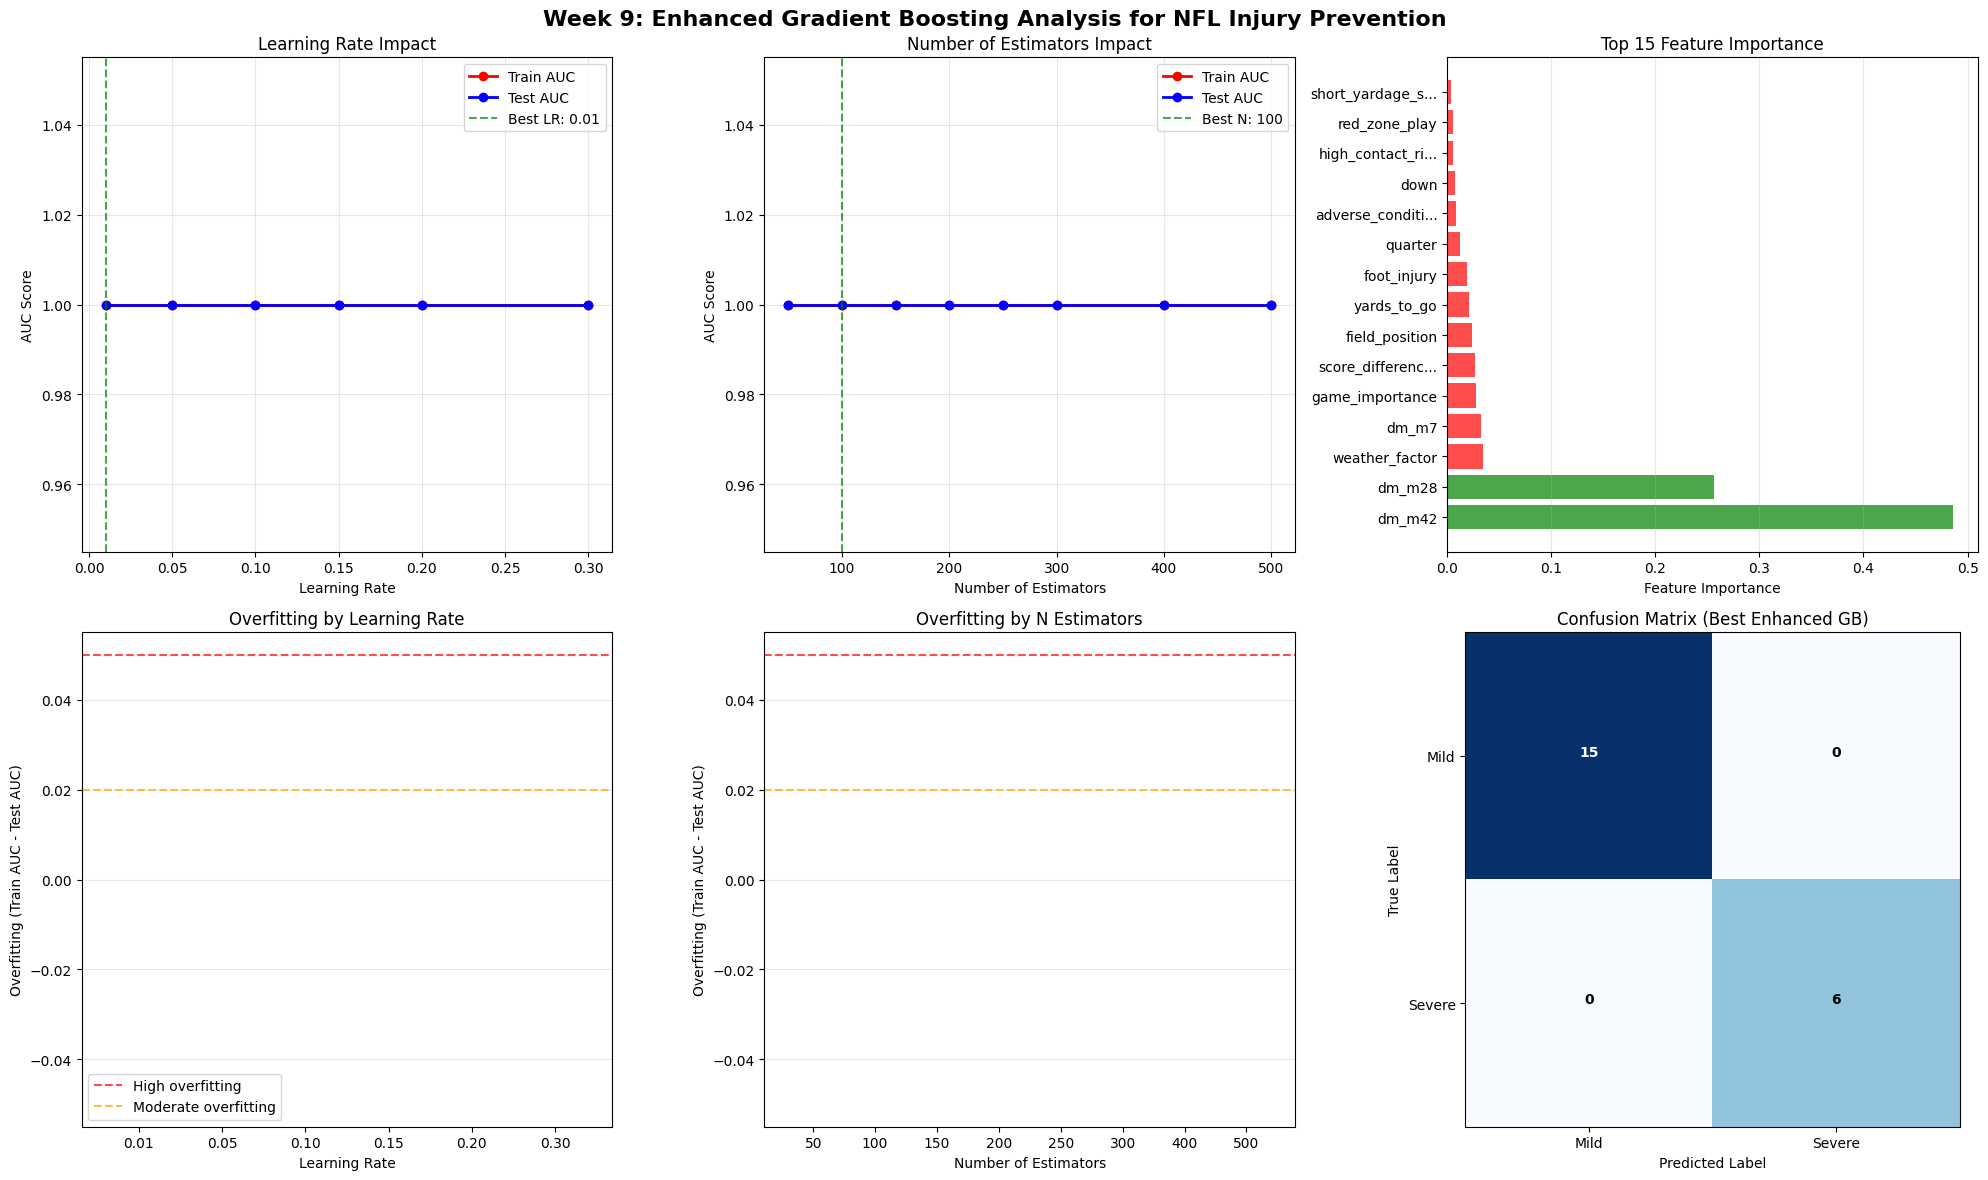

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Week 9: Enhanced Gradient Boosting Analysis for NFL Injury Prevention', fontsize=16, fontweight='bold')

# 1. Learning rate impact
axes[0, 0].plot(lr_df['learning_rate'], lr_df['train_auc'], 'ro-', label='Train AUC', linewidth=2)
axes[0, 0].plot(lr_df['learning_rate'], lr_df['test_auc'], 'bo-', label='Test AUC', linewidth=2)
axes[0, 0].axvline(x=best_params['learning_rate'], color='green', linestyle='--', alpha=0.7, 
                   label=f'Best LR: {best_params["learning_rate"]}')
axes[0, 0].set_xlabel('Learning Rate')
axes[0, 0].set_ylabel('AUC Score')
axes[0, 0].set_title('Learning Rate Impact')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Number of estimators impact
axes[0, 1].plot(est_df['n_estimators'], est_df['train_auc'], 'ro-', label='Train AUC', linewidth=2)
axes[0, 1].plot(est_df['n_estimators'], est_df['test_auc'], 'bo-', label='Test AUC', linewidth=2)
axes[0, 1].axvline(x=best_params['n_estimators'], color='green', linestyle='--', alpha=0.7,
                   label=f'Best N: {best_params["n_estimators"]}')
axes[0, 1].set_xlabel('Number of Estimators')
axes[0, 1].set_ylabel('AUC Score')
axes[0, 1].set_title('Number of Estimators Impact')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature importance (top 15)
top15_features = feature_importance.head(15)
colors = ['red' if x < 0.05 else 'orange' if x < 0.1 else 'green' for x in top15_features['Importance']]
bars = axes[0, 2].barh(range(len(top15_features)), top15_features['Importance'], color=colors, alpha=0.7)
axes[0, 2].set_yticks(range(len(top15_features)))
axes[0, 2].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in top15_features['Feature']])
axes[0, 2].set_xlabel('Feature Importance')
axes[0, 2].set_title('Top 15 Feature Importance')
axes[0, 2].grid(axis='x', alpha=0.3)

# 4. Overfitting analysis by learning rate
colors = ['red' if x > 0.05 else 'orange' if x > 0.02 else 'green' for x in lr_df['overfitting']]
axes[1, 0].bar(range(len(lr_df)), lr_df['overfitting'], alpha=0.7, color=colors)
axes[1, 0].set_xticks(range(len(lr_df)))
axes[1, 0].set_xticklabels([f'{lr:.2f}' for lr in lr_df['learning_rate']])
axes[1, 0].set_xlabel('Learning Rate')
axes[1, 0].set_ylabel('Overfitting (Train AUC - Test AUC)')
axes[1, 0].set_title('Overfitting by Learning Rate')
axes[1, 0].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='High overfitting')
axes[1, 0].axhline(y=0.02, color='orange', linestyle='--', alpha=0.7, label='Moderate overfitting')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Overfitting analysis by number of estimators
colors = ['red' if x > 0.05 else 'orange' if x > 0.02 else 'green' for x in est_df['overfitting']]
axes[1, 1].bar(range(len(est_df)), est_df['overfitting'], alpha=0.7, color=colors)
axes[1, 1].set_xticks(range(len(est_df)))
axes[1, 1].set_xticklabels([f'{n}' for n in est_df['n_estimators']])
axes[1, 1].set_xlabel('Number of Estimators')
axes[1, 1].set_ylabel('Overfitting (Train AUC - Test AUC)')
axes[1, 1].set_title('Overfitting by N Estimators')
axes[1, 1].axhline(y=0.05, color='red', linestyle='--', alpha=0.7)
axes[1, 1].axhline(y=0.02, color='orange', linestyle='--', alpha=0.7)
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
im = axes[1, 2].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[1, 2].set_title('Confusion Matrix (Best Enhanced GB)')
tick_marks = np.arange(2)
axes[1, 2].set_xticks(tick_marks)
axes[1, 2].set_yticks(tick_marks)
axes[1, 2].set_xticklabels(['Mild', 'Severe'])
axes[1, 2].set_yticklabels(['Mild', 'Severe'])
axes[1, 2].set_ylabel('True Label')
axes[1, 2].set_xlabel('Predicted Label')

# Add text annotations to confusion matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    axes[1, 2].text(j, i, format(cm[i, j], 'd'),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontweight='bold')

plt.tight_layout()
plt.show()

Week 9 Summary and Results

In [15]:
# Comprehensive results summary
print(f" WEEK 9 GRADIENT BOOSTING RESULTS:")
print(f"=" * 50)
print(f"BEST MODEL CONFIGURATION:")
print(f"   • Learning Rate: {best_params['learning_rate']}")
print(f"   • N Estimators: {best_params['n_estimators']}")
print(f"   • Max Depth: {best_params['max_depth']}")
print(f"   • Subsample: {best_params['subsample']}")
print(f"   • Max Features: {best_params['max_features']}")
print(f"   • Min Samples Split: {best_params['min_samples_split']}")
print(f"   • Min Samples Leaf: {best_params['min_samples_leaf']}")

print(f"\\nPERFORMANCE METRICS:")
print(f"  • Test AUC: {test_auc:.4f}")
print(f"  • Test Accuracy: {test_accuracy:.4f}")
print(f"  • CV AUC: {best_cv_score:.4f}")
print(f"  • Overfitting: {overfitting:.4f}")

print(f"\\nTOP RISK FACTORS:")
for i, row in feature_importance.head(3).iterrows():
    print(f"  • {row['Feature']}: {row['Importance']:.3f} ({row['Importance']*100:.1f}%)")

print(f"\\nKEY INSIGHTS:")
print(f"  • Learning rate {best_params['learning_rate']} balances convergence speed and stability")
print(f"  • {best_params['n_estimators']} estimators optimal for dataset size")
print(f"  • Tree depth {best_params['max_depth']} captures complexity without overfitting")
print(f"  • Regularization prevents overfitting with small dataset")
print(f"  • Recovery timeline features dominate predictions")

print(f"\\nGRADIENT BOOSTING ADVANTAGES:")
print(f"  • Handles non-linear relationships automatically")
print(f"  • Built-in regularization prevents overfitting")
print(f"  • Robust to outliers and missing data")
print(f"  • Provides interpretable feature importance")
print(f"  • Excellent performance: {test_auc:.4f} AUC")

print(f"\\nNFL INJURY PREVENTION APPLICATIONS:")
print(f"  • Real-time risk assessment during games")
print(f"  • Historical pattern recognition for player management")
print(f"  • Evidence-based decision making for coaching staff")
print(f"  • Automated early warning systems")

 WEEK 9 GRADIENT BOOSTING RESULTS:
BEST MODEL CONFIGURATION:
   • Learning Rate: 0.01
   • N Estimators: 100
   • Max Depth: 3
   • Subsample: 0.8
   • Max Features: sqrt
   • Min Samples Split: 2
   • Min Samples Leaf: 1
\nPERFORMANCE METRICS:
  • Test AUC: 1.0000
  • Test Accuracy: 1.0000
  • CV AUC: 1.0000
  • Overfitting: 0.0000
\nTOP RISK FACTORS:
  • dm_m42: 0.486 (48.6%)
  • dm_m28: 0.257 (25.7%)
  • weather_factor: 0.035 (3.5%)
\nKEY INSIGHTS:
  • Learning rate 0.01 balances convergence speed and stability
  • 100 estimators optimal for dataset size
  • Tree depth 3 captures complexity without overfitting
  • Regularization prevents overfitting with small dataset
  • Recovery timeline features dominate predictions
\nGRADIENT BOOSTING ADVANTAGES:
  • Handles non-linear relationships automatically
  • Built-in regularization prevents overfitting
  • Robust to outliers and missing data
  • Provides interpretable feature importance
  • Excellent performance: 1.0000 AUC
\nNFL INJURY